In [1]:
import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#import tensorflow_datasets as tfds
import tensorflow.keras.optimizers
import tensorflow.keras.metrics
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cartopy.crs as ccrs
import cartopy.feature as cf
import pickle 
from datetime import date
import xarray as xr
import netCDF4 as nc
#from u_interpolate_small import regrid_irregular_quick
import u_interpolate_small as uint
from ndays import numOfDays
import glob
import calendar
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

2024-06-15 23:09:13.642746: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define domain and time period
start_lat = 10 # 5 
end_lat = 20 #10
start_lon = -18 #-10
end_lon = -8 #0
start_year = '2010'
start_month = '07'
end_year = '2010'
end_month = '08'
start_day = '01'
end_day = '31'


# find ndays
date1 = date(int(start_year), int(start_month), int(start_day))
date2 = date(int(end_year), int(end_month), int(end_day))
t = numOfDays(date1, date2)+1


In [3]:
# get native MSG grid (core)
coords_filename= './nxny1640_580_nxnyds164580_blobdx0.04491576_area4_n23_20_32.nc'#[0]  # this is /prj/Africa_cloud/geoloc/*.npz on the Linux system
msg_file = xr.open_dataset(coords_filename).squeeze() # pick any convective core file from ch9_wavelet. 
mlon = msg_file['lons_mid'].values
mlat = msg_file['lats_mid'].values
# find core indices using one file
lat_ind = np.where((mlat[:,1]>=start_lat) & (mlat[:,1]<=end_lat))[0]
lon_ind = np.where((mlon[1,:]>=start_lon) & (mlon[1,:]<=end_lon))[0]
lat = mlat[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
lon = mlon[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
#lon = lon_fl[(lon_fl>= start_lon) & (lon_fl<=end_lon)]
#X, Y = np.meshgrid(lon,lat)

cores = np.zeros((t*96,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
tir = np.zeros((t*96,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
time_core = np.zeros((t*96)) #using every fourth value for hourly comparison- 24hr

In [4]:
# read in cores data
list_of_file_names = []

if int(start_year)==int(end_year): 
    for m in range(int(start_month),int(end_month)+1,1): # 1 to include the end month
        if m<10:
            month = str(m).zfill(2)
        else:
            month = str(m)  
        for d in range(1,calendar.monthrange(int(start_year), m)[1]+1,1): # 1 to include the end month
            if d<10:
                day = str(d).zfill(2)
            else:
                day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
            dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
            all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
            list_of_file_names.append(all_file_names) # all days in month
        #if os.path.isfile(all_file_names):      
         #   list_of_file_names.append(all_file_names) # all days in month
        #else:
         #   list_of_file_names.append('file_not_available') # all days in month
            #print(all_file_names)
             
elif int(start_year)<int(end_year):
    y=1
    for i in range(int(start_year),int(end_year)+1,1):
        if y==1:
            for m in range(int(start_month),10,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)  
                for d in range(1,calendar.monthrange(i, m)[1]+1,1):
                #for d in range(1,30,1): # 1 to include the end month
                    if d<10:
                        day = str(d).zfill(2)
                    else:
                        day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
                    dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
                    all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
                    list_of_file_names.append(all_file_names) # all days in month
            #print((all_file_names))
                #print(len(all_file_names))
                y=y+1
                month=[]
            
        else:
            for m in range(1,int(end_month)+1,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)    
                for d in range(1,calendar.monthrange(i, m)[1]+1,1):
                    if d<10:
                        day = str(d).zfill(2)
                    else:
                        day = str(d)  
                    dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
                    all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
                    list_of_file_names.append(all_file_names) # all days in month
                  
list_of_files=[]                
for a in range(0,len(list_of_file_names),1):
    list_of_files = list_of_files+list_of_file_names[a]
#if int(start_year)<int(end_year):
 #   list_of_files = list_of_files[0]+list_of_files[1]
#else:
   # list_of_files = list_of_files[0]#+list_of_files[1]    
print(len(list_of_files))

5952


In [5]:
for l in range(0,len(list_of_files),1):#, min(t*96,len(list_of_files)), 4):#range(len(list_of_files)): # 96 files per day
    core_filename = list_of_files[l]#'/prj/Africa_cloud/ch9_wavelet/'+str(i)+'/'+month+'/'  list_of_files[l]
    print(core_filename)
    #if os.path.isfile(all_file_names):      
    ds = xr.open_dataset(core_filename).squeeze() 
    print(l)
    core_temp = ds['msg_cores'].values
    cores[l,:,:] = core_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
    #uint.interpolate_data(ds['cores'].values, inds, weights, shape) # interpolation using saved weights for MSG cores       
    tir_temp =  ds['msg_Tir'].values/10000
    tir[l,:,:] = tir_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]    
    time_core[l] = int(core_filename[-15:-3])
    #else:
     #   cores[:,:,l] = cores_temp*np.nan  
      #  tir[:,:,l] = tir_temp*np.nan   
       # time_core[l] = (core_filename[-15:-3])
  

/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010000.nc
0
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010015.nc
1
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010030.nc
2
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010045.nc
3
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010100.nc
4
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010115.nc
5
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010130.nc
6
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010145.nc
7
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010200.nc
8
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010215.nc
9
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010230.nc
10
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010245.nc
11
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010300.nc
12
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010315.nc
13
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010330.nc
14
/prj/

124
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020715.nc
125
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020730.nc
126
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020745.nc
127
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020800.nc
128
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020815.nc
129
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020830.nc
130
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020845.nc
131
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020900.nc
132
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020915.nc
133
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020930.nc
134
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020945.nc
135
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021000.nc
136
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021015.nc
137
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021030.nc
138
/prj/nflics/hist_cores/2010/07/02/Hist_cores

247
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031400.nc
248
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031415.nc
249
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031430.nc
250
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031445.nc
251
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031500.nc
252
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031515.nc
253
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031530.nc
254
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031545.nc
255
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031600.nc
256
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031615.nc
257
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031630.nc
258
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031645.nc
259
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031700.nc
260
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031715.nc
261
/prj/nflics/hist_cores/2010/07/03/Hist_cores

369
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042030.nc
370
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042045.nc
371
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042100.nc
372
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042115.nc
373
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042130.nc
374
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042145.nc
375
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042200.nc
376
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042215.nc
377
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042230.nc
378
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042245.nc
379
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042300.nc
380
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042315.nc
381
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042330.nc
382
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042345.nc
383
/prj/nflics/hist_cores/2010/07/05/Hist_cores

/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060245.nc
491
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060300.nc
492
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060315.nc
493
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060330.nc
494
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060345.nc
495
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060400.nc
496
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060415.nc
497
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060430.nc
498
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060445.nc
499
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060500.nc
500
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060515.nc
501
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060530.nc
502
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060545.nc
503
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060600.nc
504
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_

/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070900.nc
612
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070915.nc
613
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070930.nc
614
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070945.nc
615
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071000.nc
616
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071015.nc
617
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071030.nc
618
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071045.nc
619
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071100.nc
620
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071115.nc
621
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071130.nc
622
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071145.nc
623
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071200.nc
624
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071215.nc
625
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_

/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081530.nc
734
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081545.nc
735
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081600.nc
736
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081615.nc
737
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081630.nc
738
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081645.nc
739
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081700.nc
740
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081715.nc
741
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081730.nc
742
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081745.nc
743
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081800.nc
744
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081815.nc
745
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081830.nc
746
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081845.nc
747
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_

/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092200.nc
856
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092215.nc
857
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092230.nc
858
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092245.nc
859
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092300.nc
860
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092315.nc
861
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092330.nc
862
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092345.nc
863
/prj/nflics/hist_cores/2010/07/10/Hist_cores_wa_201007100000.nc
864
/prj/nflics/hist_cores/2010/07/10/Hist_cores_wa_201007100015.nc
865
/prj/nflics/hist_cores/2010/07/10/Hist_cores_wa_201007100030.nc
866
/prj/nflics/hist_cores/2010/07/10/Hist_cores_wa_201007100045.nc
867
/prj/nflics/hist_cores/2010/07/10/Hist_cores_wa_201007100100.nc
868
/prj/nflics/hist_cores/2010/07/10/Hist_cores_wa_201007100115.nc
869
/prj/nflics/hist_cores/2010/07/10/Hist_cores_wa_

/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110430.nc
978
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110445.nc
979
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110500.nc
980
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110515.nc
981
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110530.nc
982
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110545.nc
983
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110600.nc
984
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110615.nc
985
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110630.nc
986
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110645.nc
987
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110700.nc
988
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110715.nc
989
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110730.nc
990
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110745.nc
991
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_

/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121030.nc
1098
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121045.nc
1099
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121100.nc
1100
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121115.nc
1101
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121130.nc
1102
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121145.nc
1103
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121200.nc
1104
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121215.nc
1105
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121230.nc
1106
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121245.nc
1107
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121300.nc
1108
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121315.nc
1109
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121330.nc
1110
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121345.nc
1111
/prj/nflics/hist_cores/2010/07/12/

/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131645.nc
1219
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131700.nc
1220
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131715.nc
1221
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131730.nc
1222
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131745.nc
1223
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131800.nc
1224
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131815.nc
1225
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131830.nc
1226
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131845.nc
1227
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131900.nc
1228
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131915.nc
1229
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131930.nc
1230
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131945.nc
1231
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007132000.nc
1232
/prj/nflics/hist_cores/2010/07/13/

1337
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142230.nc
1338
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142245.nc
1339
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142300.nc
1340
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142315.nc
1341
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142330.nc
1342
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142345.nc
1343
/prj/nflics/hist_cores/2010/07/15/Hist_cores_wa_201007150000.nc
1344
/prj/nflics/hist_cores/2010/07/15/Hist_cores_wa_201007150015.nc
1345
/prj/nflics/hist_cores/2010/07/15/Hist_cores_wa_201007150030.nc
1346
/prj/nflics/hist_cores/2010/07/15/Hist_cores_wa_201007150045.nc
1347
/prj/nflics/hist_cores/2010/07/15/Hist_cores_wa_201007150100.nc
1348
/prj/nflics/hist_cores/2010/07/15/Hist_cores_wa_201007150115.nc
1349
/prj/nflics/hist_cores/2010/07/15/Hist_cores_wa_201007150130.nc
1350
/prj/nflics/hist_cores/2010/07/15/Hist_cores_wa_201007150145.nc
1351
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160415.nc
1457
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160430.nc
1458
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160445.nc
1459
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160500.nc
1460
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160515.nc
1461
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160530.nc
1462
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160545.nc
1463
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160600.nc
1464
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160615.nc
1465
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160630.nc
1466
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160645.nc
1467
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160700.nc
1468
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160715.nc
1469
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160730.nc
1470
/prj/nflics/hist_cores/2010/07/16/

1575
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171000.nc
1576
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171015.nc
1577
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171030.nc
1578
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171045.nc
1579
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171100.nc
1580
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171115.nc
1581
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171130.nc
1582
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171145.nc
1583
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171200.nc
1584
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171215.nc
1585
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171230.nc
1586
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171245.nc
1587
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171300.nc
1588
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171315.nc
1589
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181600.nc
1696
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181615.nc
1697
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181630.nc
1698
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181645.nc
1699
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181700.nc
1700
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181715.nc
1701
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181730.nc
1702
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181745.nc
1703
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181800.nc
1704
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181815.nc
1705
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181830.nc
1706
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181845.nc
1707
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181900.nc
1708
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181915.nc
1709
/prj/nflics/hist_cores/2010/07/18/

1814
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192145.nc
1815
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192200.nc
1816
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192215.nc
1817
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192230.nc
1818
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192245.nc
1819
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192300.nc
1820
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192315.nc
1821
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192330.nc
1822
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192345.nc
1823
/prj/nflics/hist_cores/2010/07/20/Hist_cores_wa_201007200000.nc
1824
/prj/nflics/hist_cores/2010/07/20/Hist_cores_wa_201007200015.nc
1825
/prj/nflics/hist_cores/2010/07/20/Hist_cores_wa_201007200030.nc
1826
/prj/nflics/hist_cores/2010/07/20/Hist_cores_wa_201007200045.nc
1827
/prj/nflics/hist_cores/2010/07/20/Hist_cores_wa_201007200100.nc
1828
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210330.nc
1934
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210345.nc
1935
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210400.nc
1936
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210415.nc
1937
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210430.nc
1938
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210445.nc
1939
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210500.nc
1940
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210515.nc
1941
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210530.nc
1942
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210545.nc
1943
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210600.nc
1944
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210615.nc
1945
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210630.nc
1946
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210645.nc
1947
/prj/nflics/hist_cores/2010/07/21/

/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220915.nc
2053
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220930.nc
2054
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220945.nc
2055
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221000.nc
2056
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221015.nc
2057
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221030.nc
2058
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221045.nc
2059
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221100.nc
2060
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221115.nc
2061
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221130.nc
2062
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221145.nc
2063
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221200.nc
2064
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221215.nc
2065
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221230.nc
2066
/prj/nflics/hist_cores/2010/07/22/

2172
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231515.nc
2173
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231530.nc
2174
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231545.nc
2175
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231600.nc
2176
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231615.nc
2177
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231630.nc
2178
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231645.nc
2179
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231700.nc
2180
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231715.nc
2181
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231730.nc
2182
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231745.nc
2183
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231800.nc
2184
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231815.nc
2185
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231830.nc
2186
/prj/nflics/hist_cores/2010/0

2292
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242115.nc
2293
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242130.nc
2294
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242145.nc
2295
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242200.nc
2296
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242215.nc
2297
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242230.nc
2298
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242245.nc
2299
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242300.nc
2300
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242315.nc
2301
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242330.nc
2302
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242345.nc
2303
/prj/nflics/hist_cores/2010/07/25/Hist_cores_wa_201007250000.nc
2304
/prj/nflics/hist_cores/2010/07/25/Hist_cores_wa_201007250015.nc
2305
/prj/nflics/hist_cores/2010/07/25/Hist_cores_wa_201007250030.nc
2306
/prj/nflics/hist_cores/2010/0

2412
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260315.nc
2413
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260330.nc
2414
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260345.nc
2415
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260400.nc
2416
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260415.nc
2417
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260430.nc
2418
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260445.nc
2419
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260500.nc
2420
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260515.nc
2421
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260530.nc
2422
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260545.nc
2423
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260600.nc
2424
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260615.nc
2425
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260630.nc
2426
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270915.nc
2533
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270930.nc
2534
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270945.nc
2535
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271000.nc
2536
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271015.nc
2537
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271030.nc
2538
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271045.nc
2539
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271100.nc
2540
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271115.nc
2541
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271130.nc
2542
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271145.nc
2543
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271200.nc
2544
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271215.nc
2545
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271230.nc
2546
/prj/nflics/hist_cores/2010/07/27/

/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281500.nc
2652
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281515.nc
2653
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281530.nc
2654
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281545.nc
2655
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281600.nc
2656
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281615.nc
2657
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281630.nc
2658
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281645.nc
2659
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281700.nc
2660
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281715.nc
2661
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281730.nc
2662
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281745.nc
2663
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281800.nc
2664
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281815.nc
2665
/prj/nflics/hist_cores/2010/07/28/

2772
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292115.nc
2773
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292130.nc
2774
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292145.nc
2775
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292200.nc
2776
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292215.nc
2777
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292230.nc
2778
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292245.nc
2779
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292300.nc
2780
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292315.nc
2781
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292330.nc
2782
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292345.nc
2783
/prj/nflics/hist_cores/2010/07/30/Hist_cores_wa_201007300000.nc
2784
/prj/nflics/hist_cores/2010/07/30/Hist_cores_wa_201007300015.nc
2785
/prj/nflics/hist_cores/2010/07/30/Hist_cores_wa_201007300030.nc
2786
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310315.nc
2893
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310330.nc
2894
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310345.nc
2895
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310400.nc
2896
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310415.nc
2897
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310430.nc
2898
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310445.nc
2899
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310500.nc
2900
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310515.nc
2901
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310530.nc
2902
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310545.nc
2903
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310600.nc
2904
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310615.nc
2905
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310630.nc
2906
/prj/nflics/hist_cores/2010/07/31/

3012
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010915.nc
3013
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010930.nc
3014
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010945.nc
3015
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011000.nc
3016
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011015.nc
3017
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011030.nc
3018
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011045.nc
3019
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011100.nc
3020
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011115.nc
3021
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011130.nc
3022
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011145.nc
3023
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011200.nc
3024
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011215.nc
3025
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011230.nc
3026
/prj/nflics/hist_cores/2010/0

3132
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021515.nc
3133
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021530.nc
3134
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021545.nc
3135
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021600.nc
3136
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021615.nc
3137
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021630.nc
3138
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021645.nc
3139
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021700.nc
3140
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021715.nc
3141
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021730.nc
3142
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021745.nc
3143
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021800.nc
3144
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021815.nc
3145
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021830.nc
3146
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032115.nc
3253
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032130.nc
3254
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032145.nc
3255
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032200.nc
3256
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032215.nc
3257
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032230.nc
3258
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032245.nc
3259
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032300.nc
3260
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032315.nc
3261
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032330.nc
3262
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032345.nc
3263
/prj/nflics/hist_cores/2010/08/04/Hist_cores_wa_201008040000.nc
3264
/prj/nflics/hist_cores/2010/08/04/Hist_cores_wa_201008040015.nc
3265
/prj/nflics/hist_cores/2010/08/04/Hist_cores_wa_201008040030.nc
3266
/prj/nflics/hist_cores/2010/08/04/

3372
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050315.nc
3373
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050330.nc
3374
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050345.nc
3375
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050400.nc
3376
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050415.nc
3377
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050430.nc
3378
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050445.nc
3379
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050500.nc
3380
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050515.nc
3381
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050530.nc
3382
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050545.nc
3383
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050600.nc
3384
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050615.nc
3385
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050630.nc
3386
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060915.nc
3493
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060930.nc
3494
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060945.nc
3495
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061000.nc
3496
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061015.nc
3497
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061030.nc
3498
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061045.nc
3499
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061100.nc
3500
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061115.nc
3501
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061130.nc
3502
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061145.nc
3503
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061200.nc
3504
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061215.nc
3505
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061230.nc
3506
/prj/nflics/hist_cores/2010/08/06/

/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071515.nc
3613
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071530.nc
3614
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071545.nc
3615
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071600.nc
3616
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071615.nc
3617
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071630.nc
3618
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071645.nc
3619
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071700.nc
3620
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071715.nc
3621
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071730.nc
3622
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071745.nc
3623
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071800.nc
3624
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071815.nc
3625
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071830.nc
3626
/prj/nflics/hist_cores/2010/08/07/

/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082100.nc
3732
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082115.nc
3733
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082130.nc
3734
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082145.nc
3735
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082200.nc
3736
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082215.nc
3737
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082230.nc
3738
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082245.nc
3739
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082300.nc
3740
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082315.nc
3741
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082330.nc
3742
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082345.nc
3743
/prj/nflics/hist_cores/2010/08/09/Hist_cores_wa_201008090000.nc
3744
/prj/nflics/hist_cores/2010/08/09/Hist_cores_wa_201008090015.nc
3745
/prj/nflics/hist_cores/2010/08/09/

3851
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100300.nc
3852
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100315.nc
3853
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100330.nc
3854
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100345.nc
3855
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100400.nc
3856
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100415.nc
3857
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100430.nc
3858
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100445.nc
3859
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100500.nc
3860
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100515.nc
3861
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100530.nc
3862
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100545.nc
3863
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100600.nc
3864
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100615.nc
3865
/prj/nflics/hist_cores/2010/0

3972
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110915.nc
3973
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110930.nc
3974
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110945.nc
3975
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111000.nc
3976
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111015.nc
3977
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111030.nc
3978
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111045.nc
3979
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111100.nc
3980
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111115.nc
3981
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111130.nc
3982
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111145.nc
3983
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111200.nc
3984
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111215.nc
3985
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111230.nc
3986
/prj/nflics/hist_cores/2010/0

4092
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121515.nc
4093
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121530.nc
4094
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121545.nc
4095
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121600.nc
4096
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121615.nc
4097
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121630.nc
4098
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121645.nc
4099
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121700.nc
4100
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121715.nc
4101
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121730.nc
4102
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121745.nc
4103
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121800.nc
4104
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121815.nc
4105
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121830.nc
4106
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132100.nc
4212
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132115.nc
4213
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132130.nc
4214
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132145.nc
4215
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132200.nc
4216
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132215.nc
4217
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132230.nc
4218
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132245.nc
4219
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132300.nc
4220
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132315.nc
4221
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132330.nc
4222
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132345.nc
4223
/prj/nflics/hist_cores/2010/08/14/Hist_cores_wa_201008140000.nc
4224
/prj/nflics/hist_cores/2010/08/14/Hist_cores_wa_201008140015.nc
4225
/prj/nflics/hist_cores/2010/08/14/

4330
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150245.nc
4331
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150300.nc
4332
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150315.nc
4333
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150330.nc
4334
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150345.nc
4335
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150400.nc
4336
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150415.nc
4337
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150430.nc
4338
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150445.nc
4339
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150500.nc
4340
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150515.nc
4341
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150530.nc
4342
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150545.nc
4343
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150600.nc
4344
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160830.nc
4450
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160845.nc
4451
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160900.nc
4452
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160915.nc
4453
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160930.nc
4454
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160945.nc
4455
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008161000.nc
4456
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008161015.nc
4457
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008161030.nc
4458
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008161045.nc
4459
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008161100.nc
4460
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008161115.nc
4461
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008161130.nc
4462
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008161145.nc
4463
/prj/nflics/hist_cores/2010/08/16/

/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171415.nc
4569
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171430.nc
4570
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171445.nc
4571
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171500.nc
4572
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171515.nc
4573
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171530.nc
4574
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171545.nc
4575
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171600.nc
4576
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171615.nc
4577
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171630.nc
4578
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171645.nc
4579
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171700.nc
4580
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171715.nc
4581
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171730.nc
4582
/prj/nflics/hist_cores/2010/08/17/

4687
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182000.nc
4688
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182015.nc
4689
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182030.nc
4690
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182045.nc
4691
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182100.nc
4692
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182115.nc
4693
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182130.nc
4694
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182145.nc
4695
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182200.nc
4696
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182215.nc
4697
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182230.nc
4698
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182245.nc
4699
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182300.nc
4700
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182315.nc
4701
/prj/nflics/hist_cores/2010/0

4807
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200200.nc
4808
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200215.nc
4809
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200230.nc
4810
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200245.nc
4811
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200300.nc
4812
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200315.nc
4813
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200330.nc
4814
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200345.nc
4815
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200400.nc
4816
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200415.nc
4817
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200430.nc
4818
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200445.nc
4819
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200500.nc
4820
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200515.nc
4821
/prj/nflics/hist_cores/2010/0

4927
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210800.nc
4928
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210815.nc
4929
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210830.nc
4930
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210845.nc
4931
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210900.nc
4932
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210915.nc
4933
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210930.nc
4934
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210945.nc
4935
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008211000.nc
4936
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008211015.nc
4937
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008211030.nc
4938
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008211045.nc
4939
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008211100.nc
4940
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008211115.nc
4941
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221345.nc
5047
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221400.nc
5048
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221415.nc
5049
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221430.nc
5050
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221445.nc
5051
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221500.nc
5052
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221515.nc
5053
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221530.nc
5054
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221545.nc
5055
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221600.nc
5056
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221615.nc
5057
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221630.nc
5058
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221645.nc
5059
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221700.nc
5060
/prj/nflics/hist_cores/2010/08/22/

5167
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232000.nc
5168
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232015.nc
5169
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232030.nc
5170
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232045.nc
5171
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232100.nc
5172
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232115.nc
5173
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232130.nc
5174
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232145.nc
5175
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232200.nc
5176
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232215.nc
5177
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232230.nc
5178
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232245.nc
5179
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232300.nc
5180
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232315.nc
5181
/prj/nflics/hist_cores/2010/0

5286
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250145.nc
5287
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250200.nc
5288
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250215.nc
5289
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250230.nc
5290
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250245.nc
5291
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250300.nc
5292
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250315.nc
5293
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250330.nc
5294
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250345.nc
5295
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250400.nc
5296
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250415.nc
5297
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250430.nc
5298
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250445.nc
5299
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250500.nc
5300
/prj/nflics/hist_cores/2010/0

5407
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260800.nc
5408
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260815.nc
5409
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260830.nc
5410
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260845.nc
5411
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260900.nc
5412
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260915.nc
5413
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260930.nc
5414
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260945.nc
5415
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008261000.nc
5416
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008261015.nc
5417
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008261030.nc
5418
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008261045.nc
5419
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008261100.nc
5420
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008261115.nc
5421
/prj/nflics/hist_cores/2010/0

5526
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271345.nc
5527
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271400.nc
5528
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271415.nc
5529
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271430.nc
5530
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271445.nc
5531
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271500.nc
5532
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271515.nc
5533
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271530.nc
5534
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271545.nc
5535
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271600.nc
5536
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271615.nc
5537
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271630.nc
5538
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271645.nc
5539
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271700.nc
5540
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281945.nc
5647
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282000.nc
5648
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282015.nc
5649
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282030.nc
5650
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282045.nc
5651
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282100.nc
5652
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282115.nc
5653
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282130.nc
5654
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282145.nc
5655
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282200.nc
5656
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282215.nc
5657
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282230.nc
5658
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282245.nc
5659
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282300.nc
5660
/prj/nflics/hist_cores/2010/08/28/

5766
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300145.nc
5767
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300200.nc
5768
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300215.nc
5769
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300230.nc
5770
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300245.nc
5771
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300300.nc
5772
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300315.nc
5773
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300330.nc
5774
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300345.nc
5775
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300400.nc
5776
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300415.nc
5777
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300430.nc
5778
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300445.nc
5779
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300500.nc
5780
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310730.nc
5886
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310745.nc
5887
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310800.nc
5888
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310815.nc
5889
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310830.nc
5890
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310845.nc
5891
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310900.nc
5892
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310915.nc
5893
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310930.nc
5894
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310945.nc
5895
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008311000.nc
5896
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008311015.nc
5897
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008311030.nc
5898
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008311045.nc
5899
/prj/nflics/hist_cores/2010/08/31/

In [5]:
## a clean way of plotting - use matplotlib functions directly:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
def draw_map(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


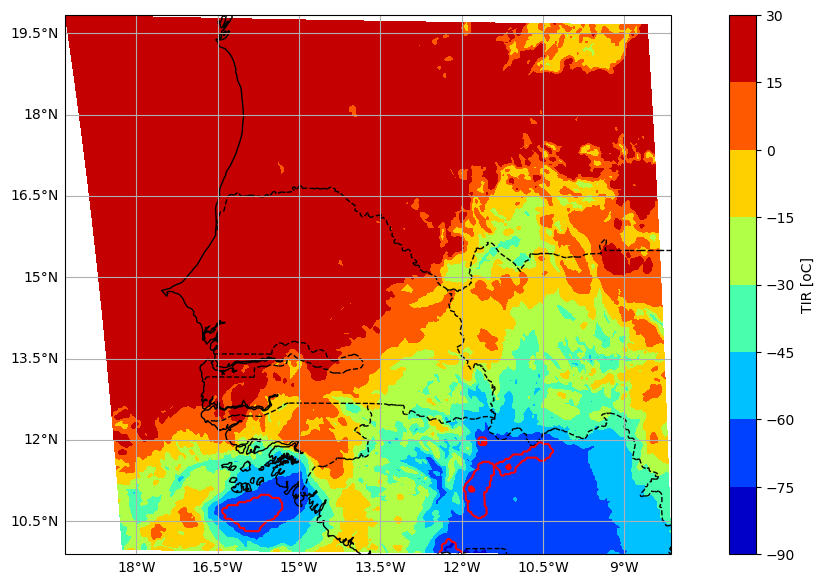

In [7]:
day = 1
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, tir[day,:,:], lon, lat,  cbar_label='TIR [oC]', cmap='jet')
# ax.contour(lon, lat, cores[day,:,:], levels=[-5,1,50], colors='r')
ax.contour(lon, lat, cores[day,:,:], colors='r')

#

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


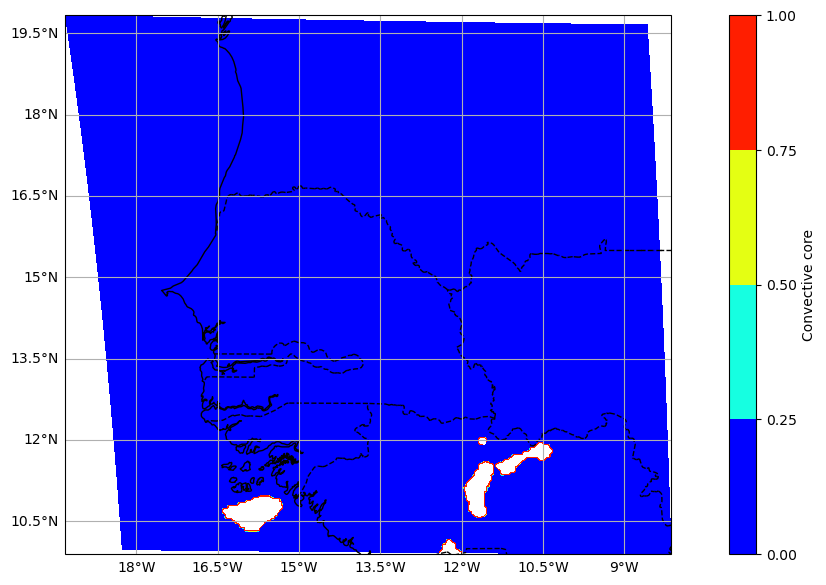

In [8]:
day = 1
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, cores[day,:,:], lon, lat,levels=[0,0.25, 0.5,0.75, 1], cbar_label='Convective core', cmap='jet')
# ax.contour(lon, lat, cores[day,:,:], levels=[-5,1,50], colors='r')
#ax.contour(lon, lat, cores[day,:,:], colors='r')


In [9]:
print(cores.shape)


(5952, 341, 354)


In [10]:
# save variables 
#with open('pkl_files/WA_subdomain_cores_15min_Jul_Aug.pkl', 'wb') as file: 
          #pickle.dump([cores, tir, time_core], file) 
        #

In [6]:
# open a file, where you stored the pickled data
with open('../pkl_files/WA_subdomain_cores_15min_Jul_Aug.pkl', 'rb') as file: 
    data = pickle.load(file)
    cores= data[0]
    tir= data[1]
    time_core= data[2]


In [7]:
# input data- cores_t_0: 
# starting at 
num_frames= 3   # previous 2 hours of images to predict 1 hr later
t0= 1  #1   30 min  later (4 frames at 15 min)
a= 85
b= 98
#cores_t_minus_xhr = cores[0:-2*t0, a:,b:]
#cores_t_0 = cores[t0:-t0, a:,b:]
#tir_t_minus_xhr = tir[0:-2*t0,a:,b:]
#tir_t_0 = tir[t0:-t0, a:,b:]
ind = np.where(cores>0)
cores[ind] = 1
cores_t_0 = cores[0:(-num_frames-t0)*4, :-a,b:]
tir_t_0 = tir[0:(-num_frames-t0)*4, :-a,b:]
ind_tir = np.where(tir_t_0>-0.01)
tir_t_0[ind_tir] = 0
tir_t_0[np.isnan(tir_t_0)] = 0
tir_t_0 = tir_t_0/np.min(tir_t_0)
#hist_cores_t_0 = hist_cores[0:-num_frames-t0, :-a,b:]

#target data
cores_t_plus_xhr = cores[(t0+num_frames)*4:,:-a,b:]
prediction_time = time_core[(t0+num_frames)*4:]


In [8]:
np.min(tir_t_0)

-0.0

In [9]:
print(cores_t_0.shape)
print(tir_t_0.shape)
print(cores_t_plus_xhr.shape)

(5936, 256, 256)
(5936, 256, 256)
(5936, 256, 256)


In [10]:
# training data
tir_t_0_minus_2 = tir_t_0[0:-2*4]
tir_t_0_minus_1 = tir_t_0[1*4:-1*4]
tir_t_0 = tir_t_0[2*4:]
cores_t_plus_xhr = cores_t_plus_xhr[2*4:]
prediction_time = prediction_time[2*4:]

In [11]:
print(tir_t_0_minus_2.shape)
print(tir_t_0_minus_1.shape)
print(tir_t_0.shape)
print(cores_t_plus_xhr.shape)
print(prediction_time.shape)



(5928, 256, 256)
(5928, 256, 256)
(5928, 256, 256)
(5928, 256, 256)
(5928,)


In [ ]:
# Define input shape
#num_frames= 24  # 6 hours
image_height= len(cores_t_plus_xhr[1,:,1]) #lat
image_width= len(cores_t_plus_xhr[1,1,:]) #lon
num_channels= 3 #  core at t0-, core at t0-1,  



In [13]:
total_samples= int(tir_t_0.shape[0])
x_train= np.zeros((total_samples,image_height,image_width, num_channels))

x_train[:,:,:,0]= tir_t_0_minus_2
x_train[:,:,:,1]= tir_t_0_minus_1
x_train[:,:,:,2]= tir_t_0
y_train= cores_t_plus_xhr

x_tr, x_test, y_tr, y_test, time_tr, time_test = train_test_split(x_train,y_train,prediction_time, test_size=0.1,random_state=42)


In [14]:
print(x_tr.shape)
print(x_test.shape)
print(y_test.shape)
print(time_tr.shape)
print(time_test.shape)


(5335, 256, 256, 3)
(593, 256, 256, 3)
(593, 256, 256)
(5335,)
(593,)


In [15]:
def plot_maps(ax, lon, lat, data, title,levels_custom):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap='jet')  # this is the actual plot
    ax.coastlines()   ## adds coastlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    #cbar = plt.colorbar(m)  # adds colorbar
    #cbar.set_label('core')

In [16]:
def plot_maps_colorbar(ax, lon, lat, data, title,levels_custom):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap='jet')  # this is the actual plot
    ax.coastlines()   ## adds coastlines
    xl = ax.gridlines(draw_labels=False);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    cbar.set_label('Probability of Core')

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D)
from tensorflow.keras import layers


# Define input shape
image_height= len(cores_t_plus_xhr[1,:,1]) #
image_width= len(cores_t_plus_xhr[1,1,:]) #
num_channels= 3 #   


# define conv layer
def conv_layer(x_in, filters, gn_num, strides = 1, shape = (image_height,image_width), name=None):
    x = Conv2D(filters, 5, strides=strides, padding='same')(x_in)
    x = Activation('relu', name = name)(x)
   ## x = layers.BatchNormalization()(x)
    #x = tfa.layers.GroupNormalization(groups=gn_num, axis=3)(x) # could replace this with BatchNorm
    return x


# def basic unet structure
def unet_basic(input_shape=(image_height, image_width, num_channels), meta_input_shape=1 ,chan_num=num_channels):

    inputs = Input(shape=input_shape)    # 256 x 256 x 2
    meta_inputs = Input(shape=meta_input_shape)

    # downsample
    down2 = conv_layer(inputs, 4, 1)     # 256 x 256 x 4
    down2_pool = MaxPooling2D((2, 2), strides=None)(down2)   # 128 x 128 x 4

    down3 = conv_layer(down2_pool, 8, None) # 128 x 128 x 8
    down3_pool = MaxPooling2D((4, 4), strides=None)(down3) # 32 x 32 x 8
    
    
    #bottom of a U net style segmentation architecture.
    flattened = layers.Flatten()(down3_pool)
    center = layers.concatenate([flattened, meta_inputs])

    #center = conv_layer(center, 8, None) # 32 x 32 x 8
   # center1 = UpSampling2D((4, 4))(center) # 128 x 128 x 8    
 
    # upsample
    up3 = UpSampling2D((4, 4))(center1) # 128 x 128 x 8
    up3 = concatenate([down3, up3], axis=3) # 128 x 128 x 8
    up3 = conv_layer(up3, 4, None) # 128 x 128 x 4

    up2 = UpSampling2D((2, 2))(up3) # 256 x 256 x 4
    up2 = concatenate([down2, up2], axis=3) # 256 x 256 x 4
    up2 = conv_layer(up2, 4, None) # 256 x 256 x 4
    

    # predict
    output = Conv2D(1, (1, 1))(up2)
    output = layers.Activation('sigmoid', dtype='float32', name='prob_pred')(output)

    # create model object
    unet = Model(inputs=inputs, outputs=output, name = 'prob_map_unet')
    return unet


# build model - error here
unet_model = unet_basic(input_shape=(image_height, image_width, num_channels),meta_input_shape=1, chan_num=num_channels)


# compile model
unet_model.compile(optimizer=tensorflow.keras.optimizers.Adam(),
                  loss=FSS_loss,
                  metrics="accuracy")


# Define modifiable training hyperparameters.
epochs =  20
batch_size = 4 #50# batch_size#24
y_tr=tf.expand_dims(y_tr, axis=3)


# Fit the model to the training data.
model_history = unet_model.fit(x_tr,
                               y_tr,
                               batch_size=batch_size,
                               epochs=epochs,
                               validation_split = 0.1)


In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D)
from tensorflow.keras import layers
#import tensorflow_addons as tfa # this is only for GroupNormalization which can be replaced by keras BatchNorm

def conv_layer(x_in, filters, gn_num, strides = 1, shape = (image_height,image_width), name=None):
    x = Conv2D(filters, 5, strides=strides, padding='same')(x_in)
    x = Activation('relu', name = name)(x)
   ## x = layers.BatchNormalization()(x)
    #x = tfa.layers.GroupNormalization(groups=gn_num, axis=3)(x) # could replace this with BatchNorm
    return x


In [21]:
def unet_basic(input_shape=(image_height, image_width, num_channels), meta_input_shape=1 ,chan_num=num_channels):

    inputs = Input(shape=input_shape)    # 256 x 256 x 2
    meta_inputs = Input(shape=meta_input_shape)

    down2 = conv_layer(inputs, 4, 1)     # 256 x 256 x 4
    down2_pool = MaxPooling2D((2, 2), strides=None)(down2)   # 128 x 128 x 4

    down3 = conv_layer(down2_pool, 8, None) # 128 x 128 x 8
 #   down3 = conv_layer(down3, 32, 4) # 64 x 64 x 32
    down3_pool = MaxPooling2D((4, 4), strides=None)(down3) # 32 x 32 x 8

    #center = conv_layer(down3_pool, 16, None) # 32 x 32 x 16
    
    
       #bottom of a U net style segmentation architecture.
    flattened = layers.Flatten()(down3_pool)
    center = layers.concatenate([flattened, meta_inputs])

    #center = conv_layer(center, 8, None) # 32 x 32 x 8
   # center1 = UpSampling2D((4, 4))(center) # 128 x 128 x 8

    # center
    
 
    up3 = UpSampling2D((4, 4))(center1) # 128 x 128 x 8
    # note the skip-connections that join same-dimension
    # stages of the down branch and up branch of the U:
    up3 = concatenate([down3, up3], axis=3) # 128 x 128 x 8
 #   up3 = conv_layer(up3, 32, 16) # 64 x 64 x 32
    up3 = conv_layer(up3, 4, None) # 128 x 128 x 4

    up2 = UpSampling2D((2, 2))(up3) # 256 x 256 x 4
    up2 = concatenate([down2, up2], axis=3) # 256 x 256 x 4
    up2 = conv_layer(up2, 4, None) # 256 x 256 x 4
  #  up2 = conv_layer(up2, 8, 8) # 128 x 128 x 8
    #up2 = conv_layer(up2, 32, 8)


    # predict
    output = Conv2D(1, (1, 1))(up2)
        # could add an activation here to get output in desired form, e.g. for a probability map:
    output = layers.Activation('sigmoid', dtype='float32', name='prob_pred')(output)

    # create model object
    unet = Model(inputs=inputs, outputs=output, name = 'prob_map_unet')
        # can also return intermediate feature maps along with the final probability map if desired, e.g.:
        ##unet = Model(inputs=inputs, outputs=[output, up0a], name = 'prob_map_unet')
    return unet

In [22]:
unet_model = unet_basic(input_shape=(image_height, image_width, num_channels),meta_input_shape=1, chan_num=num_channels)


ValueError: Input 0 of layer "up_sampling2d" is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 8193)

In [20]:
unet_model.summary()

Model: "prob_map_unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 4)  304         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 256, 256, 4)  0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 4)  0           ['activation[0][0]'] 

In [21]:
def _create_mean_filter(half_num_rows, half_num_columns, num_channels):
    """Creates convolutional filter that computes mean.

    M = number of rows in filter
    N = number of columns in filter
    C = number of channels

    :param half_num_rows: Number of rows on either side of center.  This is
        (M - 1) / 2.
    :param half_num_columns: Number of columns on either side of center.  This
        is (N - 1) / 2.
    :param num_channels: Number of channels.
    :return: weight_matrix: M-by-N-by-C-by-C numpy array of filter weights.
    """

    num_rows = 2 * half_num_rows + 1
    num_columns = 2 * half_num_columns + 1
    weight = 1. / (num_rows * num_columns)

    return np.full(
        (num_rows, num_columns, num_channels, num_channels), weight,
        dtype=np.float32
    )


In [22]:
def FSS_loss(target_tensor, prediction_tensor):
    
    half_window_size_px=2
    use_as_loss_function=True 
    #mask_matrix
    function_name=None
    test_mode=False
    """Fractions skill score (FSS).

    M = number of rows in grid
    N = number of columns in grid

    :param half_window_size_px: Number of pixels (grid cells) in half of
        smoothing window (on either side of center).  If this argument is K, the
        window size will be (1 + 2 * K) by (1 + 2 * K).
    :param use_as_loss_function: Boolean flag.  FSS is positively oriented
        (higher is better), but if using it as loss function, we want it to be
        negatively oriented.  Thus, if `use_as_loss_function == True`, will
        return 1 - FSS.  If `use_as_loss_function == False`, will return just
        FSS.
    :param mask_matrix: M-by-N numpy array of Boolean flags.  Grid cells marked
        "False" are masked out and not used to compute the loss.
    :param function_name: Function name (string).
    :param test_mode: Leave this alone.
    :return: loss: Loss function (defined below).
    """

    weight_matrix = _create_mean_filter(
        half_num_rows=half_window_size_px,
        half_num_columns=half_window_size_px, num_channels=1
    )
       
    #print(target_tensor.shape)
    #print(prediction_tensor.shape)
    #print(weight_matrix.shape)
        
    """Computes loss (fractions skill score).

        :param target_tensor: Tensor of target (actual) values.
        :param prediction_tensor: Tensor of predicted values.
        :return: loss: Fractions skill score.
    """

    smoothed_target_tensor = K.conv2d(
        x=target_tensor, kernel=weight_matrix,
        padding='same', strides=(1, 1), data_format='channels_last'
    )

    smoothed_prediction_tensor = K.conv2d(
        x=prediction_tensor, kernel=weight_matrix,
        padding='same', strides=(1, 1), data_format='channels_last'
    )

    #smoothed_target_tensor = smoothed_target_tensor * eroded_mask_matrix
    #smoothed_prediction_tensor = smoothed_prediction_tensor * eroded_mask_matrix)

    actual_mse = K.mean(
        (smoothed_target_tensor - smoothed_prediction_tensor) ** 2
    )
    reference_mse = K.mean(
        smoothed_target_tensor ** 2 + smoothed_prediction_tensor ** 2
    )

    if use_as_loss_function:
        return actual_mse / reference_mse

    return 1. - actual_mse / reference_mse

    if function_name is not None:
        loss.__name__ = function_name



In [23]:
unet_model.compile(optimizer=tensorflow.keras.optimizers.Adam(),
                  loss=FSS_loss,
                  metrics="accuracy")
#                  metrics=metric_list)

                   #"binary_crossentropy",

In [24]:
print(x_tr.shape)
print(y_tr.shape)


(5335, 256, 256, 3)
(5335, 256, 256)


In [25]:
# Define modifiable training hyperparameters.
epochs =  20
batch_size = 4 #50# batch_size#24
y_tr=tf.expand_dims(y_tr, axis=3)

# Fit the model to the training data.
model_history = unet_model.fit(x_tr,
                               y_tr,
                               batch_size=batch_size,
                               epochs=epochs,
                               validation_split = 0.1)
#    callbacks=[early_stopping, reduce_lr],


Epoch 1/20
1201/1201 [==============================] - 179s 148ms/step - loss: 0.8415 - accuracy: 0.9843 - val_loss: 0.8048 - val_accuracy: 0.9838
Epoch 2/20
1201/1201 [==============================] - 174s 145ms/step - loss: 0.7973 - accuracy: 0.9820 - val_loss: 0.7928 - val_accuracy: 0.9806
Epoch 3/20
1201/1201 [==============================] - 177s 147ms/step - loss: 0.7884 - accuracy: 0.9802 - val_loss: 0.7778 - val_accuracy: 0.9808
Epoch 4/20
1201/1201 [==============================] - 177s 147ms/step - loss: 0.7842 - accuracy: 0.9788 - val_loss: 0.7864 - val_accuracy: 0.9829
Epoch 5/20
1201/1201 [==============================] - 177s 148ms/step - loss: 0.7731 - accuracy: 0.9789 - val_loss: 0.7683 - val_accuracy: 0.9835
Epoch 6/20
1201/1201 [==============================] - 176s 147ms/step - loss: 0.7702 - accuracy: 0.9791 - val_loss: 0.7723 - val_accuracy: 0.9817
Epoch 7/20
1201/1201 [==============================] - 177s 147ms/step - loss: 0.7600 - accuracy: 0.9793 - val_

In [59]:
#with open('pkl_files/WA_subdomain_cores_15min_Jul_Aug_trained_model_3channel_4hr_TIR_SELF.pkl', 'wb') as file: 
    #pickle.dump(unet_model, file) 

#with open("pkl_files/WA_subdomain_cores_15min_Jul_Aug_trained_model_3channel_4hr_TIR_SELF.pkl", "rb") as file:
    #unet_model = pickle.load(file)

In [54]:
# example date = 201008121545.0
ind = np.where(np.logical_and(time_test>= 201008121000, time_test<= 201008121900)) 
#for b in range(0,51,1):
batch_number = ind[0][0] # 20 # 0,1
frames = x_test[batch_number,:,:,:] # 
original_frame = y_test[batch_number,:,:] # 
print(frames.shape)


# Extract the model's prediction and post-process it.
predicted_frame = unet_model.predict(np.expand_dims(frames, axis=0))

(256, 256, 3)
1/1 [==============================] - 0s 17ms/step


In [55]:
print(predicted_frame.shape)
#print(np.unique(predicted_frame))

(1, 256, 256, 1)


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


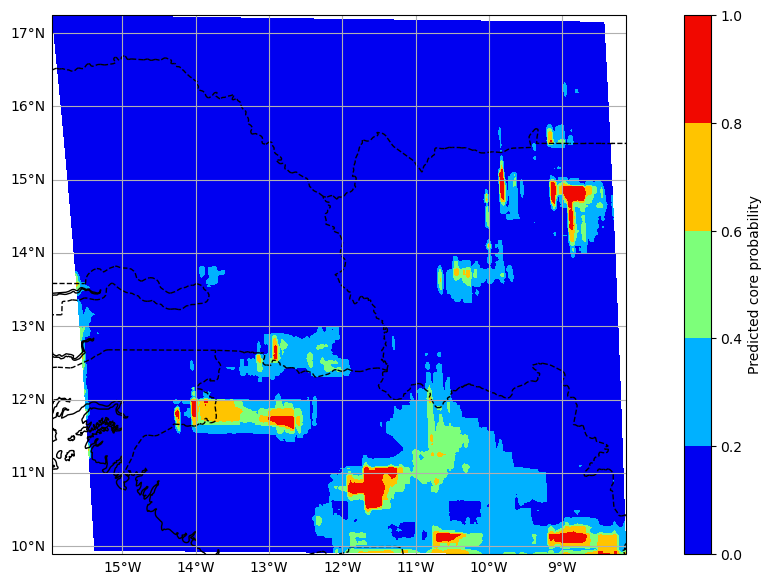

In [56]:
t0= 0#1   #*4 # # 15 min  later (4 frames at 15 min)
a= 85
b= 98

f=plt.figure(figsize=(15,7)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) 
draw_map(ax, np.squeeze(predicted_frame[0,:,:,0]), lon[:-a,b:], lat[:-a,b:],levels=[0, 0.2, 0.4, 0.6, 0.8,1], cbar_label='Predicted core probability', cmap='jet')

#np.

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility

201008121830.0


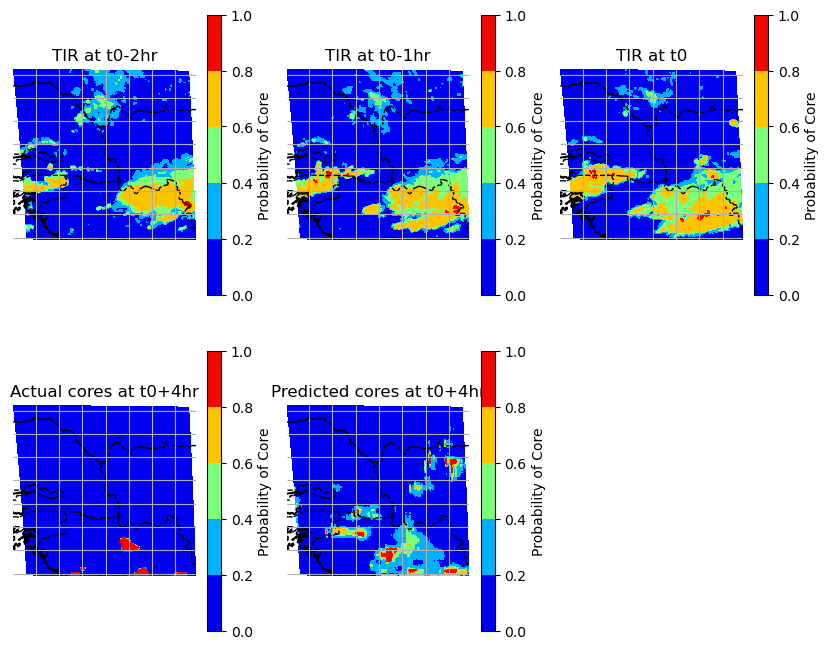

In [57]:
data = np.zeros((5,image_height,image_width))
data[0] = np.squeeze(frames[:,:,0])
data[1] = np.squeeze(frames[:,:,1])
data[2] = np.squeeze(frames[:,:,2])
data[3] = np.squeeze(original_frame[:,:])
data[4] = np.squeeze(predicted_frame[0,:,:,0])
titles = ['TIR at t0-2hr','TIR at t0-1hr','TIR at t0', 'Actual cores at t0+4hr', 'Predicted cores at t0+4hr']
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],[0, 0.2, 0.4, 0.6, 0.8,1],np.arange(0,1.05,0.2)]

fig, axes = plt.subplots(2, 3, figsize=(10, 8),
                         subplot_kw={'projection':ccrs.PlateCarree()})
axes[1][2].set_visible(False)

for idx, ax in enumerate(axes[0]):
    plot_maps_colorbar(ax, lon[:-a,b:], lat[:-a,b:], data[idx],  title=None ,levels_custom= levels_custom[0])
    ax.set_title(titles[idx])
    ax.axis("off")

for idx, ax in enumerate(axes[1]):
    if idx==2:
        break
    plot_maps_colorbar(ax, lon[:-a,b:], lat[:-a,b:], data[idx+3],  title=None ,levels_custom= levels_custom[0])
    ax.set_title(titles[idx+3])
    ax.axis("off")
    

# Print information and display the figure.
#print('Predicting core at 1hr')
print(time_test[batch_number])
plt.show()

(256, 256, 3)
1/1 [==============================] - 0s 20ms/step


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility

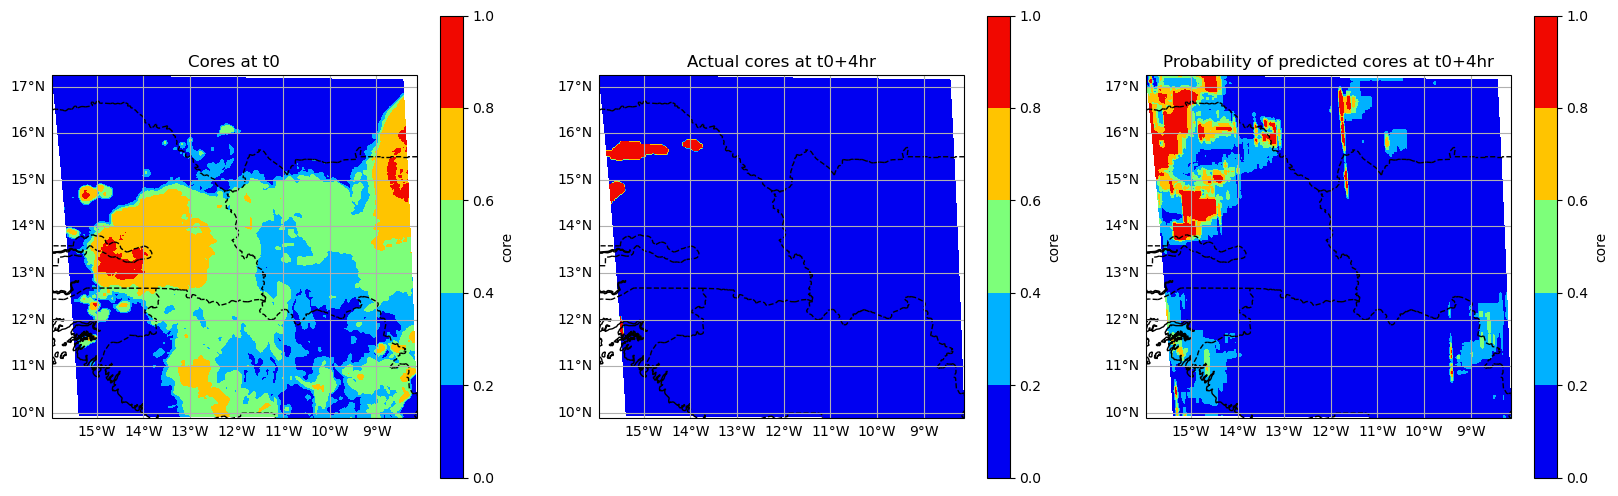

In [39]:
#for b in range(0,51,1):
batch_number = 100 # 0,1
frames = x_test[batch_number,:,:,:] # 
original_frame = y_test[batch_number,:,:] # 
print(frames.shape)


# Extract the model's prediction and post-process it.
predicted_frame = unet_model.predict(np.expand_dims(frames, axis=0))

# plot data
data = np.zeros((3,image_height,image_width))
#data[0] = np.squeeze(frames[day-4*t0,:,:,0])
data[0] = np.squeeze(frames[:,:,0])
data[1] = np.squeeze(original_frame[:,:])
data[2] = np.squeeze(predicted_frame[0,:,:,0])
#titles = ['Cores at t0-1hr', 'Cores at t0', 'Probability of cores at t0+1hr']
titles = ['Cores at t0', 'Actual cores at t0+4hr', 'Probability of predicted cores at t0+4hr']
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],[0, 0.2, 0.4, 0.6, 0.8,1],np.arange(0,1.05,0.2)]

fig, axes = plt.subplots(1, 3, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})

i=0
for ax in axes:
    m= ax.contourf(lon[:-a,b:], lat[:-a,b:], data[i], transform=ccrs.PlateCarree(), levels=levels_custom[i],cmap='jet')  # this is the actual plot
# ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(titles[i])
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    cbar.set_label('core')
    i=i+1
 
#plt.show()

In [40]:
frames= np.zeros((image_height,image_width, num_channels))
predicted_frames= np.zeros((x_test.shape[0],image_height,image_width))

for i in range(0,x_test.shape[0],1):
    #batch_number = 10 # 0,1
    frames[:,:,:] = x_test[i,:,:,:] # 
    #original_frame[i,:,:] = y_test[i,:,:] # 
    
    # Extract the model's prediction and post-process it.
    predicted_frames[i,:,:] = np.squeeze(unet_model.predict(np.expand_dims(frames, axis=0)))
    
    

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


In [41]:
#import tensorflow_addons as tfa
#metric =  tfa.metrics.F1Score(threshold=0.5)
#metric.update_state(y_test.flatten(), predicted_frame.flatten())
#result = metric.result()
#result.numpy()
#import tensorflow.keras.metrics
#tensorflow.keras.metrics.F1Score(average=None, threshold=None, name='f1_score', dtype=None)


In [42]:
fpr, tpr, thresholds = metrics.roc_curve(y_test.flatten(), predicted_frames.flatten())

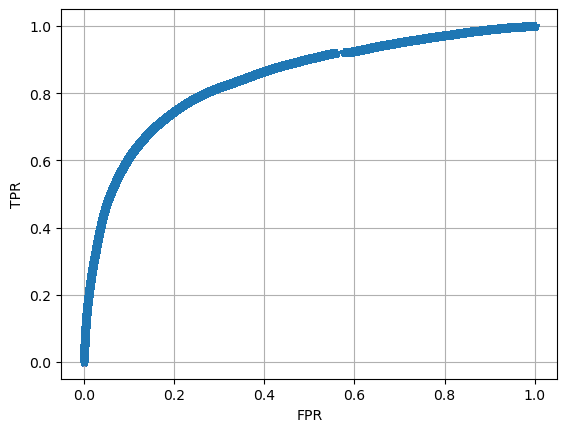

In [43]:
# Create a line plot
plt.plot(fpr, tpr,linestyle='-',marker="*")
plt.xlabel('FPR')
plt.ylabel('TPR')
# Show the plot
plt.grid()
plt.show()

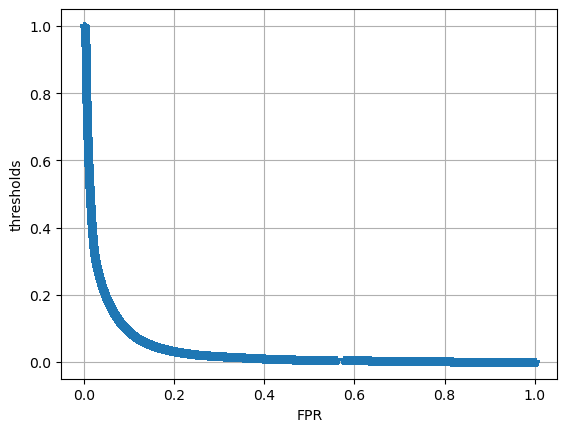

In [44]:
# Create a line plot
plt.plot(fpr, thresholds,linestyle='-',marker="*")
#plt.text(0.7, 0.2, 'threshold=0.03', fontsize = 12)
plt.xlabel('FPR')
plt.ylabel('thresholds')
# Show the plot
plt.grid()
plt.show()

In [45]:
core_prob_threshold = 0.1
y_pred = np.zeros((x_test.shape[0],image_height,image_width))
ind_okay = np.where(predicted_frames>core_prob_threshold)
y_pred[ind_okay] = 1


In [46]:
# 0.03
tn, fp, fn, tp= confusion_matrix(y_test.flatten(), y_pred.flatten()).ravel()
print(tn, fp, fn, tp)

34828130 3532133 205534 297051


In [47]:
a=(tn, fp, fn, tp)
print(a/(tn+ fp+ fn+ tp))

[0.89618059 0.09088714 0.0052887  0.00764357]


In [48]:
def FSS_accuracy_metric(target_tensor, prediction_tensor,half_window_size_px):
    
    half_window_size_px=half_window_size_px #2
    use_as_loss_function=False 
    #mask_matrix
    test_mode=False
    """Fractions skill score (FSS).

    M = number of rows in grid
    N = number of columns in grid

    :param half_window_size_px: Number of pixels (grid cells) in half of
        smoothing window (on either side of center).  If this argument is K, the
        window size will be (1 + 2 * K) by (1 + 2 * K).
    :param use_as_loss_function: Boolean flag.  FSS is positively oriented
        (higher is better), but if using it as loss function, we want it to be
        negatively oriented.  Thus, if `use_as_loss_function == True`, will
        return 1 - FSS.  If `use_as_loss_function == False`, will return just
        FSS.
    :param mask_matrix: M-by-N numpy array of Boolean flags.  Grid cells marked
        "False" are masked out and not used to compute the loss.
    :param function_name: Function name (string).
    :param test_mode: Leave this alone.
    :return: loss: Loss function (defined below).
    """

    weight_matrix = _create_mean_filter(
        half_num_rows=half_window_size_px,
        half_num_columns=half_window_size_px, num_channels=1
    )
              
    """Computes loss (fractions skill score).

        :param target_tensor: Tensor of target (actual) values.
        :param prediction_tensor: Tensor of predicted values.
        :return: loss: Fractions skill score.
    """

    smoothed_target_tensor = K.conv2d(
        x=target_tensor, kernel=weight_matrix,
        padding='same', strides=(1, 1), data_format='channels_last'
    )

    smoothed_prediction_tensor = K.conv2d(
        x=prediction_tensor, kernel=weight_matrix,
        padding='same', strides=(1, 1), data_format='channels_last'
    )

    #smoothed_target_tensor = smoothed_target_tensor * eroded_mask_matrix
    #smoothed_prediction_tensor = smoothed_prediction_tensor * eroded_mask_matrix)

    actual_mse = K.mean(
        (smoothed_target_tensor - smoothed_prediction_tensor) ** 2
    )
    reference_mse = K.mean(
        smoothed_target_tensor ** 2 + smoothed_prediction_tensor ** 2
    )

    if use_as_loss_function:
        return actual_mse / reference_mse

    return 1. - actual_mse / reference_mse



In [59]:
y_test1= tf.expand_dims(y_test, axis=3)
y_test1= tf.cast(y_test1, tf.float32)
ffs_array=[]
prob_threshold=[]

for core_prob_threshold in range(0,11,1):
    y_pred = np.zeros((x_test.shape[0],image_height,image_width))
    ind_okay = np.where(predicted_frames>core_prob_threshold/10)
    y_pred[ind_okay] = 1
    y_pred1 = tf.expand_dims(y_pred, axis=3)
    y_pred1 = tf.cast(y_pred1, tf.float32)
    FSS_Score = FSS_accuracy_metric(y_test1, y_pred1,2)
    print(FSS_Score)
    ffs_array.append(FSS_Score) 
    prob_threshold.append(core_prob_threshold/10)
    
    
#with open('../pkl_files/Prob_threshold_vs_Eval_FSS_scores_3channel_4hr_using_1hr_TIR.pkl', 'wb') as file: 
    #pickle.dump([prob_threshold,ffs_array], file) 
 

tf.Tensor(0.02564156, shape=(), dtype=float32)
tf.Tensor(0.15659386, shape=(), dtype=float32)
tf.Tensor(0.21314842, shape=(), dtype=float32)
tf.Tensor(0.2451489, shape=(), dtype=float32)
tf.Tensor(0.2571841, shape=(), dtype=float32)
tf.Tensor(0.25693917, shape=(), dtype=float32)
tf.Tensor(0.2497254, shape=(), dtype=float32)
tf.Tensor(0.23458087, shape=(), dtype=float32)
tf.Tensor(0.2143181, shape=(), dtype=float32)
tf.Tensor(0.19325799, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


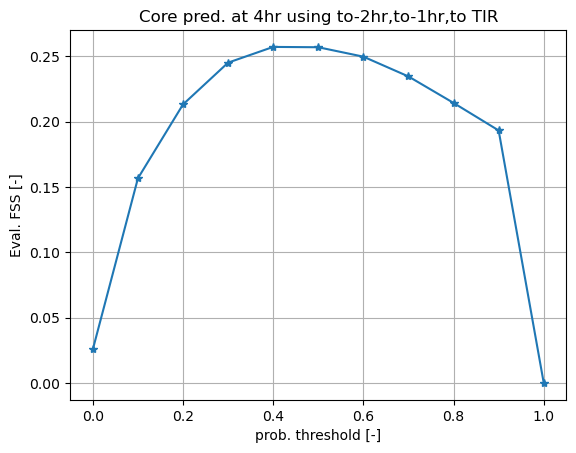

In [60]:
plt.plot(prob_threshold, ffs_array, linestyle='-',marker="*")
plt.xlabel('prob. threshold [-]')
plt.ylabel('Eval. FSS [-]')
# Show the plot
plt.title('Core pred. at 4hr using to-2hr,to-1hr,to TIR')
plt.grid()
plt.show()

In [51]:
y_test1= tf.expand_dims(y_test, axis=3)
y_test1= tf.cast(y_test1, tf.float32)
#[max_ffs, indx] = np.nax(ffs_array)
core_prob_threshold=0.3
y_pred = np.zeros((x_test.shape[0],image_height,image_width))
ind_okay = np.where(predicted_frames>core_prob_threshold)
y_pred[ind_okay] = 1
y_pred1 = tf.expand_dims(y_pred, axis=3)
y_pred1 = tf.cast(y_pred1, tf.float32)
half_window_size=[1, 2, 5, 7, 10, 13, 20, 30]
ffs_array = []
FSS_eval_kernel=[]

for FFS_kernal_size in half_window_size:
    FSS_Score = FSS_accuracy_metric(y_test1, y_pred1,FFS_kernal_size)
    print(FSS_Score)
    ffs_array.append(FSS_Score) 
    FSS_eval_kernel.append(FFS_kernal_size*2+1)
    
       

tf.Tensor(0.22791153, shape=(), dtype=float32)
tf.Tensor(0.2451489, shape=(), dtype=float32)
tf.Tensor(0.28726298, shape=(), dtype=float32)
tf.Tensor(0.31349152, shape=(), dtype=float32)
tf.Tensor(0.34877312, shape=(), dtype=float32)
tf.Tensor(0.3784064, shape=(), dtype=float32)
tf.Tensor(0.43125027, shape=(), dtype=float32)
tf.Tensor(0.4839666, shape=(), dtype=float32)


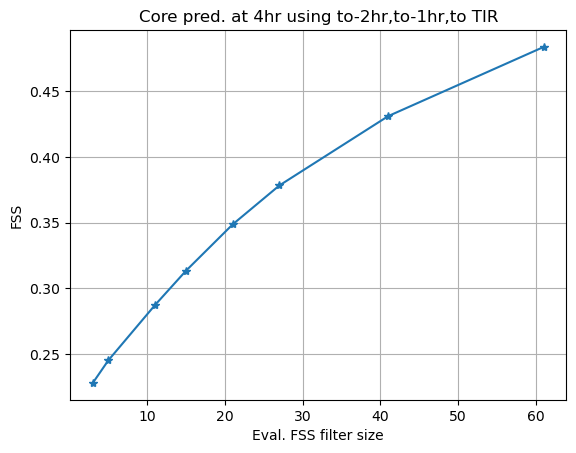

In [52]:
plt.plot(FSS_eval_kernel, ffs_array, linestyle='-',marker="*")
plt.xlabel('Eval. FSS filter [# of pixels x # of pixels]')
plt.ylabel('Eval. FSS [-]')
# Show the plot
plt.title('Core pred. at 4hr using to-2hr,to-1hr,to TIR')
plt.grid()
plt.show()

In [53]:
#with open('../pkl_files/Eval_FSS_scores_3channel_4hr_using_1hr_TIR.pkl', 'wb') as file: 
    #pickle.dump([FSS_eval_kernel,ffs_array], file) 
 